### Обучение модели для распознавания капчи

In [1]:
import os
import math
import torch
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics import CharErrorRate
from torchinfo import summary
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output

%matplotlib inline

### Set constants

In [2]:
torch.manual_seed(42)

IMAGE_WIDTH = 200
IMAGE_HEIGHT = 50
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Look at data

In [10]:
data_dir = '/content/drive/MyDrive/samples'
images = os.listdir(data_dir)
print(f'There are {len(images)} images in dataset') 

There are 1070 images in dataset


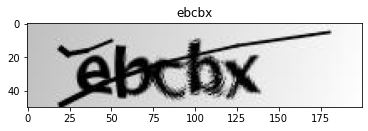

In [5]:
ind = np.random.randint(0, len(images))
img = mpimg.imread(data_dir + '/' + images[ind])
imgplot = plt.imshow(img)
plt.title(images[ind][:-4])
plt.show()

In [11]:
symbols = set()
for i in images:
    symbols.update(list(i[:-4]))
print(f'Unique symbols: {len(symbols)}')

Unique symbols: 19


In [12]:
idx2char = {k: v for k, v in enumerate(symbols, start=0)}
char2idx = {v: k for k, v in idx2char.items()}

### Define dataset and dataloader

In [13]:
n_train = int(np.floor(0.8 * len(images)))
n_val = int(np.floor(0.1 * len(images)))
n_test = len(images) - n_train - n_val
print("Train size: %d\nVal size: %d\nTest size: %d" % 
      (n_train, n_val, n_test))

assert n_train + n_val + n_test == len(images)

Train size: 856
Val size: 107
Test size: 107


In [14]:
class CaptchaDataset(Dataset):
    def __init__(self, images, img_dir=data_dir):
        self.images = images
        self.img_dir = img_dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = Image.open(img_path).convert("L")
        image = self.transform(image)
        label = self.images[idx][:-4]
        label = torch.Tensor([char2idx[char] for char in label])
        return image, label

    def transform(self, image):
        transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize(mean=0.5, std=0.25)]
        )
        return transform(image)


In [15]:
train_ds, val_ds, test_ds = random_split(images, [n_train, n_val, n_test])

trainset = CaptchaDataset(train_ds, data_dir) 
validset = CaptchaDataset(val_ds, data_dir) 
testset = CaptchaDataset(test_ds, data_dir) 

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(validset, batch_size=BATCH_SIZE)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE)

### Model

In [16]:
class CaptchaModel(nn.Module):
    def __init__(self, num_chars, dropout=0.2):
        super(CaptchaModel, self).__init__()
        self.num_chars = num_chars
        self.dropout = dropout
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3),
            nn.ReLU(),
        )
        self.linear1 = nn.Linear(256, 64)
        self.lstm = nn.LSTM(64, 32, bidirectional=True, num_layers=2, dropout=dropout)
        self.linear2 = nn.Linear(64, num_chars)

    def forward(self, batch):
        batch = self.conv(batch)  # [batch, 256, 1, 5]
        batch = batch.permute(0, 3, 1, 2)
        batch = batch.view(batch.shape[0], batch.shape[1], -1)
        batch = F.relu(self.linear1(batch))
        batch, _ = self.lstm(batch)
        batch = self.linear2(batch)  # [batch, 5, 19]
        return batch

### Model training

In [17]:
num_chars = len(symbols)

model = CaptchaModel(num_chars, dropout=0.2)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(DEVICE)
metric = CharErrorRate()

In [44]:
summary(model,  input_size=(BATCH_SIZE, 1, 50, 200))

Layer (type:depth-idx)                   Output Shape              Param #
CaptchaModel                             [32, 5, 19]               --
├─Sequential: 1-1                        [32, 256, 1, 5]           --
│    └─Conv2d: 2-1                       [32, 32, 50, 200]         320
│    └─BatchNorm2d: 2-2                  [32, 32, 50, 200]         64
│    └─MaxPool2d: 2-3                    [32, 32, 25, 100]         --
│    └─ReLU: 2-4                         [32, 32, 25, 100]         --
│    └─Conv2d: 2-5                       [32, 64, 25, 100]         18,496
│    └─BatchNorm2d: 2-6                  [32, 64, 25, 100]         128
│    └─MaxPool2d: 2-7                    [32, 64, 12, 50]          --
│    └─ReLU: 2-8                         [32, 64, 12, 50]          --
│    └─Conv2d: 2-9                       [32, 128, 12, 50]         73,856
│    └─BatchNorm2d: 2-10                 [32, 128, 12, 50]         256
│    └─MaxPool2d: 2-11                   [32, 128, 4, 16]          --
│   

In [18]:
def count_metric(preds, labels, need_errors = False):
    res = 0
    errors = []
    for idx in range(preds.shape[0]):
        pred = "".join([idx2char[idx] for idx in preds[idx].cpu().detach().numpy()])
        label = "".join([idx2char[idx] for idx in labels[idx].cpu().detach().numpy()])
        cer = metric(pred, label)
        if need_errors and not math.isclose(cer, 0.0):
            errors.append((pred, label))
        res += cer
    return res, errors


def train_model(model, train_loader, valid_loader, loss_fn, opt, n_epochs):
    train_loss_history = []
    val_loss_history = []
    val_metric_history = []

    for epoch in range(n_epochs):
        model.train(True)
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.long().to(DEVICE)
            y_pred = model(X_batch)
            y_pred = y_pred.permute(0, 2, 1)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss += loss.item() * X_batch.shape[0]

        model.eval()
        val_loss = 0.0
        val_metric = 0.0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.long().to(DEVICE)
                y_pred = model(X_batch)
                y_pred = y_pred.permute(0, 2, 1)
                loss = loss_fn(y_pred, y_batch)
                val_loss += loss.item() * X_batch.shape[0]
                metric_value, _ = count_metric(y_pred.argmax(1), y_batch)
                val_metric += metric_value
        train_loss_history.append(train_loss / len(train_loader.dataset))
        val_loss_history.append(val_loss / len(valid_loader.dataset))
        val_metric_history.append(val_metric / len(valid_loader.dataset))

        # plot loss and metric values
        clear_output(True)
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0].set_title("Loss")
        axes[0].plot(train_loss_history, label="train", color="blue")
        axes[0].plot(val_loss_history, label="validation", color="red")
        axes[0].set_xlabel("Epochs")
        axes[0].legend()
        axes[1].set_title("Validation CharErrorRate")
        axes[1].plot(val_metric_history)
        axes[1].set_xlabel("Epochs")
        plt.pause(0.01)

    return train_loss_history, val_loss_history, val_metric_history

In [19]:
model = CaptchaModel(num_chars, dropout=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(DEVICE)
metric = CharErrorRate()

n_epochs = 100

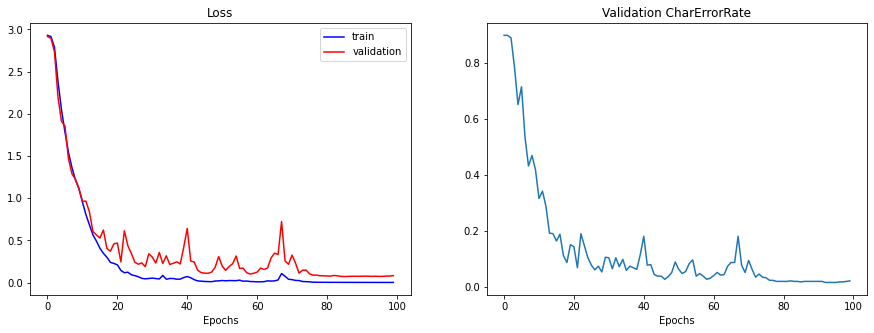

CPU times: user 2min 43s, sys: 13.1 s, total: 2min 56s
Wall time: 4min 11s


In [20]:
%%time
train_loss, val_loss, val_accuracy = train_model(model, train_loader, valid_loader, criterion, optimizer, n_epochs)

### Training results

In [21]:
print("Train loss: %.3f\nVal loss: %.3f\nMetric value: %.3f" % 
      (train_loss[-1], val_loss[-1], val_accuracy[-1]))

Train loss: 0.002
Val loss: 0.084
Metric value: 0.022


Now let`s check how model works with test data

### Test model on new data

In [22]:
def test_model(model, test_loader):
    model.eval()
    acc = 0.0
    errors = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.long().to(DEVICE)
            y_pred = model(X_batch)
            metric_value, error = count_metric(y_pred.argmax(2), y_batch, need_errors = True)
            acc += metric_value
            errors.extend(error)
    return acc / len(test_loader.dataset), errors

In [23]:
test_accuracy, errors = test_model(model, test_loader)

In [26]:
print("Metric value: %.3f\nError rate on test: %.3f" % 
      (test_accuracy, len(errors)/len(test_loader.dataset)))

Metric value: 0.030
Error rate on test: 0.112


Look at images where model was wrong

In [28]:
print(f'Number of errors: {len(errors)}')

Number of errors: 12


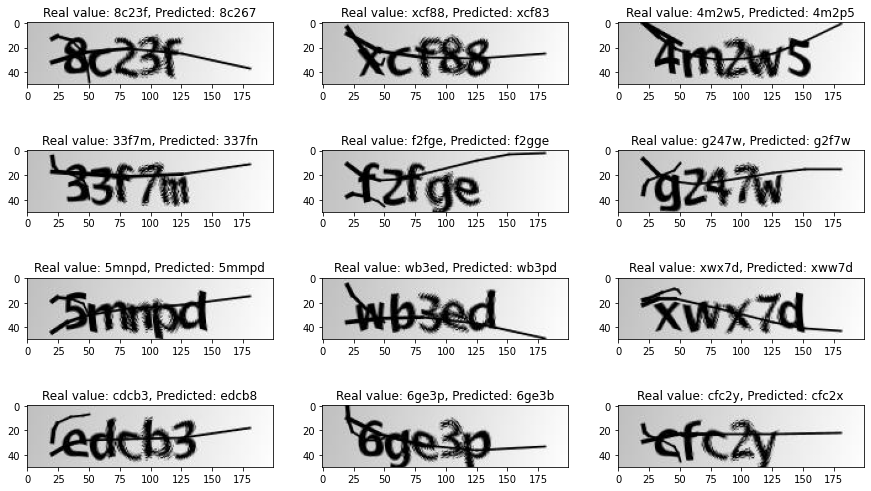

In [37]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15, 9))
ax = ax.flatten()
for i, error in enumerate(errors):
    img = mpimg.imread(data_dir + '/' + error[1] + '.png')
    #imgplot = plt.imshow(img)
    ax[i].imshow(img)
    ax[i].set_title("Real value: %s, Predicted: %s" % (error[1], error[0]))
plt.show();

We can note that model has some problems when:
- symbols with similar lines, like (3,8) or (m,n)
- symbols covered by line, like image in bottom left corner (c,e)
- symbols that are off center line, like image in bottom right corner (y, x)

To solve this problems we can:
- change model parameters
- change loss function, for example, CTCLoss
- add adaptive learning rate
- find more data or make augmentation